## Imports

In [82]:
import numpy as np
import time
import datetime
import random

from keras.callbacks import LambdaCallback
from keras.utils import plot_model
from keras.callbacks import TensorBoard

from pandas import read_csv
from Audio.Components.MidiPlayer import MidiPlayer

from keras.utils.vis_utils import model_to_dot
from keras.callbacks import LearningRateScheduler
from matplotlib import pyplot
from IPython.display import SVG
import pydot
import graphviz

from NN.networks.simple_model import create_model

from Audio.Components.helpers.prepare_arrays import get_categorized_variables
from Audio.Components.helpers.save_model import save_model
from Audio.Components.helpers.make_encoded_prediction import make_encoded_prediction
from Audio.Components.helpers.create_categorical_indicies import create_category_indicies, create_lookup_indicies
from Audio.Components.helpers.generate_phrases import generate_phrases
from Audio.Components.helpers.decode_predictions import decode_predictions
from Audio.Components.helpers.play_generated_phrase import play_generated_phrase
from Audio.Components.helpers.vectorize_phrases import vectorize_phrases
from Audio.Components.helpers.logger import logger
from Helpers.map_midi_to_note_number import map_midi_to_note_number
from Helpers.map_midi_to_interval import map_midi_to_interval
import constants

## Constants

In [115]:
player = MidiPlayer()
dropout = 0.5
n_time_steps = constants.n_time_steps
semi_redundancy_step = constants.semi_redundancy_step
lstm_size = 24
lr = constants.lr
epochs = constants.epochs
batch_size = constants.batch_size
n_to_generate = constants.n_to_generate

['Danny Bus 1', 'Danny IAC Bus 2']


In [116]:
logger('PREPROCESSING')
corpus = read_csv('Audio/data/input.csv', header=1)
print('corpus length:', len(corpus))
notes_corpus = corpus.values[:, 0]
note_name_corpus = corpus.values[:, 1]
interval_corpus = corpus.values[:, 2]
length_corpus = corpus.values[:, 3]


          **********************************
            PREPROCESSING
          **********************************
corpus length: 10611


In [117]:
categorized_variables = get_categorized_variables()

In [118]:
lookup_indicies = create_lookup_indicies(categorized_variables)

note_phrases, next_note = generate_phrases(notes_corpus, n_time_steps, semi_redundancy_step)
note_name_phrases, next_note_name = generate_phrases(note_name_corpus, n_time_steps, semi_redundancy_step)
interval_phrases, next_interval = generate_phrases(interval_corpus, n_time_steps, semi_redundancy_step)
length_phrases, next_length = generate_phrases(length_corpus, n_time_steps, semi_redundancy_step)

In [119]:
note_x, note_y = vectorize_phrases(
    phrases=note_phrases,
    n_categories=len(categorized_variables['note_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['note_index'],
    next_lookup_index=next_note
    )

interval_x, interval_y = vectorize_phrases(
    phrases=interval_phrases,
    n_categories=len(categorized_variables['interval_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['interval_index'],
    next_lookup_index=next_interval
)

note_name_x, note_name_y = vectorize_phrases(
    phrases=note_name_phrases,
    n_categories=len(categorized_variables['note_name_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['note_name_index'],
    next_lookup_index=next_note_name
)

length_x, length_y = vectorize_phrases(
    phrases=length_phrases,
    n_categories=len(categorized_variables['length_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['length_index'],
    next_lookup_index=next_length
)

print(note_x.shape, 'note_x.shape')
print(length_x.shape, 'length_x.shape')
print(interval_x.shape, 'interval_x.shape')
print(note_name_x.shape, 'note_name_x.shape')
print(note_y.shape, 'note_y.shape')
print(length_y.shape, 'length_y.shape')
print(interval_y.shape, 'interval_y.shape')
print(note_name_y.shape, 'note_name_y.shape')

(10581, 30, 128) note_x.shape
(10581, 30, 141) length_x.shape
(10581, 30, 49) interval_x.shape
(10581, 30, 13) note_name_x.shape
(10581, 128) note_y.shape
(10581, 141) length_y.shape
(10581, 49) interval_y.shape
(10581, 13) note_name_y.shape


In [120]:
model = create_model(
    categorized_variables=categorized_variables,
    lstm_size=lstm_size,
    lr=0.001,
    n_time_steps=n_time_steps,
    dropout=dropout,
)

In [121]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
note_input (InputLayer)         (None, 30, 128)      0                                            
__________________________________________________________________________________________________
note_name_input (InputLayer)    (None, 30, 13)       0                                            
__________________________________________________________________________________________________
interval_input (InputLayer)     (None, 30, 49)       0                                            
__________________________________________________________________________________________________
length_input (InputLayer)       (None, 30, 141)      0                                            
__________________________________________________________________________________________________
concatenat

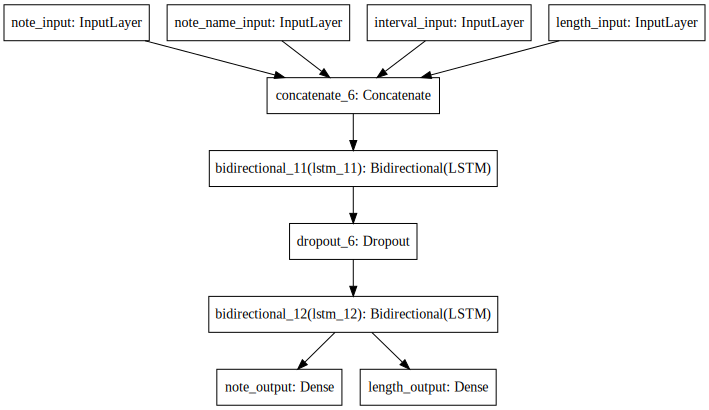

In [122]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [123]:
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.6
	epochs_drop = 25
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [124]:
def listen_callback(epoch, logs):
    if epoch % 100 == 0 and epoch > -1: 
    # if epoch < -2:
        print('----- Generating melody after Epoch: %d' % epoch)
        
        start_index = random.randint(0, 7000)
        for diversity in [0.5]:
            print('----- diversity:', diversity)

            current_note_phrase = notes_corpus[start_index: start_index + n_time_steps]
            current_interval_phrase = interval_corpus[start_index: start_index + n_time_steps]
            current_note_name_phrase = note_name_corpus[start_index: start_index + n_time_steps]
            current_length_phrase = length_corpus[start_index: start_index + n_time_steps]

            phrases = {
                'note_phrase': current_note_phrase, 
                'length_phrase': current_length_phrase,
                'interval_phrase': current_interval_phrase,
                'note_name_phrase': current_note_name_phrase,
            }

            generated_notes = []
            generated_lengths = []
            generated_notes.extend(current_note_phrase)
            generated_lengths.extend(current_length_phrase)

            # model, phrases,categorized_variables, lookup_indicies, n_time_steps, diversity, n_to_generate
            for step in range(70):
                encoded_prediction = make_encoded_prediction(
                    model=model,
                    phrases=phrases,
                    categorized_variables=categorized_variables,
                    lookup_indicies=lookup_indicies,
                    n_time_steps=n_time_steps
                )

                predictions = decode_predictions(
                    encoded_prediction=encoded_prediction,
                    lookup_indicies=lookup_indicies,
                    temperature=diversity
                )

                generated_notes.append(predictions['note_prediction']) 
                generated_lengths.append(predictions['length_prediction']) 


                last = generated_notes[0]
                phrases['note_phrase'] = np.append(phrases['note_phrase'][1:], predictions['note_prediction'])
                phrases['interval_phrase'] = map_midi_to_interval(phrases['note_phrase'], last)
                phrases['note_name_phrase'] = map_midi_to_note_number(phrases['note_phrase'])
                phrases['length_phrase'] = np.append(phrases['length_phrase'][1:], predictions['length_prediction'])

                print
                
            play_generated_phrase(
                generated_notes=generated_notes[10:],
                generated_lengths=generated_lengths[10:],
                player=player)

In [125]:
lrate = LearningRateScheduler(step_decay)

In [126]:
tensorboard = TensorBoard(log_dir="./logs/{}".format(datetime.datetime.now()), histogram_freq=0, write_graph=True)

In [127]:
listen_callback = LambdaCallback(on_epoch_end=listen_callback)

In [128]:
logger('TRAINING')
model.fit([note_x, note_name_x, interval_x, length_x], [note_y, length_y],
          batch_size=batch_size,
          epochs=1500,
          callbacks=[
              listen_callback,
#               tensorboard,
            ]
          )

          **********************************
            TRAINING
          **********************************
Epoch 1/1500
10581/10581 [==============================] - 11s 1ms/step - loss: 5.6961 - note_output_loss: 3.7594 - length_output_loss: 3.8734
----- Generating melody after Epoch: 0
----- diversity: 0.5
59.0 | 0.09
58.0 | 0.37
59.0 | 0.23
65.0 | 0.37
64.0 | 0.42
62.0 | 0.33
60.0 | 0.37
65.0 | 0.6
0 | 0.56
57.0 | 0.88
64.0 | 0.42
62.0 | 0.28
60.0 | 0.28
59.0 | 0.42
63.0 | 0.33
64.0 | 0.28
55.0 | 0.74
0 | 0.7
62.0 | 0.28
60.0 | 0.23
59 | 0.33
62 | 0.6
59 | 0.37
66 | 0.37
59 | 0.28
0 | 0.42
56 | 0.93
63 | 0.56
65 | 0.33
57 | 0.33
50 | 0.33
0 | 0.23
58 | 0.23
62 | 0.28
60 | 0.42
56 | 0.33
63 | 0.28
56 | 0.28
62 | 0.28
58 | 0.33
72 | 0.09
70 | 0.33
58 | 0.56
57 | 0.33
0 | 0.28
62 | 0.46
0 | 0.33
57 | 0.14
54 | 0.33
60 | 0.28
61 | 0.28
0 | 0.28
62 | 0.42
0 | 0.51
0 | 0.37
0 | 0.33
0 | 0.37
64 | 0.33
64 | 0.42
54 | 0.28
58 | 0.28
62 | 0.28
66 | 0.37
62 | 0.37
58 | 0.14
57 | 0.33
56 

10581/10581 [==============================] - 7s 628us/step - loss: 3.8167 - note_output_loss: 2.3159 - length_output_loss: 3.0016
Epoch 50/1500
10581/10581 [==============================] - 7s 646us/step - loss: 3.8059 - note_output_loss: 2.3057 - length_output_loss: 3.0005
Epoch 51/1500
10581/10581 [==============================] - 7s 625us/step - loss: 3.8033 - note_output_loss: 2.3061 - length_output_loss: 2.9944
Epoch 52/1500
10581/10581 [==============================] - 7s 624us/step - loss: 3.7852 - note_output_loss: 2.2883 - length_output_loss: 2.9939
Epoch 53/1500
10581/10581 [==============================] - 7s 635us/step - loss: 3.7824 - note_output_loss: 2.2847 - length_output_loss: 2.9953
Epoch 54/1500
10581/10581 [==============================] - 7s 638us/step - loss: 3.7740 - note_output_loss: 2.2781 - length_output_loss: 2.9918
Epoch 55/1500
10581/10581 [==============================] - 7s 631us/step - loss: 3.7692 - note_output_loss: 2.2746 - length_output_loss:

62 | 0.7
0 | 0.88
57 | 0.33
62 | 0.46
60 | 0.46
57 | 0.6
60 | 0.51
62 | 0.65
0 | 0.51
0 | 0.65
58 | 0.42
58 | 0.33
60 | 0.33
62 | 0.28
63 | 0.42
67 | 0.33
72 | 0.28
72 | 0.51
70 | 0.42
65 | 0.37
58 | 0.42
57 | 0.46
51 | 0.37
55 | 0.37
58 | 0.33
60 | 0.37
58 | 0.33
58 | 0.37
60 | 0.37
58 | 0.33
57 | 0.37
57 | 0.23
60 | 0.37
62 | 0.37
67 | 0.42
65 | 0.37
62 | 0.37
58 | 0.37
60 | 0.42
58 | 0.19
60 | 0.28
58 | 0.33
55 | 0.42
58 | 0.37
56 | 0.23
58 | 0.23
58 | 0.23
56 | 0.33
53 | 0.37
53 | 0.28
55 | 0.33
60 | 0.28
Epoch 102/1500
10581/10581 [==============================] - 6s 594us/step - loss: 3.4965 - note_output_loss: 2.0370 - length_output_loss: 2.9190
Epoch 103/1500
10581/10581 [==============================] - 7s 617us/step - loss: 3.4885 - note_output_loss: 2.0280 - length_output_loss: 2.9210
Epoch 104/1500
10581/10581 [==============================] - 7s 630us/step - loss: 3.4872 - note_output_loss: 2.0258 - length_output_loss: 2.9228
Epoch 105/1500
10581/10581 [================

10581/10581 [==============================] - 5s 491us/step - loss: 3.2838 - note_output_loss: 1.8468 - length_output_loss: 2.8739
Epoch 155/1500
10581/10581 [==============================] - 5s 480us/step - loss: 3.2812 - note_output_loss: 1.8459 - length_output_loss: 2.8706
Epoch 156/1500
10581/10581 [==============================] - 5s 488us/step - loss: 3.2855 - note_output_loss: 1.8513 - length_output_loss: 2.8685
Epoch 157/1500
10581/10581 [==============================] - 5s 493us/step - loss: 3.2708 - note_output_loss: 1.8376 - length_output_loss: 2.8666
Epoch 158/1500
10581/10581 [==============================] - 5s 492us/step - loss: 3.2746 - note_output_loss: 1.8387 - length_output_loss: 2.8717
Epoch 159/1500
10581/10581 [==============================] - 5s 501us/step - loss: 3.2697 - note_output_loss: 1.8353 - length_output_loss: 2.8689
Epoch 160/1500
10581/10581 [==============================] - 5s 490us/step - loss: 3.2735 - note_output_loss: 1.8401 - length_output

10581/10581 [==============================] - 7s 662us/step - loss: 3.1412 - note_output_loss: 1.7233 - length_output_loss: 2.8357
Epoch 204/1500
10581/10581 [==============================] - 7s 620us/step - loss: 3.1356 - note_output_loss: 1.7207 - length_output_loss: 2.8298
Epoch 205/1500
10581/10581 [==============================] - 7s 615us/step - loss: 3.1339 - note_output_loss: 1.7155 - length_output_loss: 2.8367
Epoch 206/1500
10581/10581 [==============================] - 7s 619us/step - loss: 3.1313 - note_output_loss: 1.7155 - length_output_loss: 2.8316
Epoch 207/1500
10581/10581 [==============================] - 7s 620us/step - loss: 3.1202 - note_output_loss: 1.7053 - length_output_loss: 2.8299
Epoch 208/1500
10581/10581 [==============================] - 7s 627us/step - loss: 3.1271 - note_output_loss: 1.7102 - length_output_loss: 2.8339
Epoch 209/1500
10581/10581 [==============================] - 6s 607us/step - loss: 3.1215 - note_output_loss: 1.7060 - length_output

10581/10581 [==============================] - 7s 651us/step - loss: 3.0068 - note_output_loss: 1.6052 - length_output_loss: 2.8032
Epoch 259/1500
10581/10581 [==============================] - 7s 621us/step - loss: 3.0065 - note_output_loss: 1.6037 - length_output_loss: 2.8057
Epoch 260/1500
10581/10581 [==============================] - 7s 624us/step - loss: 3.0036 - note_output_loss: 1.6026 - length_output_loss: 2.8020
Epoch 261/1500
10581/10581 [==============================] - 7s 626us/step - loss: 2.9974 - note_output_loss: 1.5940 - length_output_loss: 2.8069
Epoch 262/1500
10581/10581 [==============================] - 7s 644us/step - loss: 3.0060 - note_output_loss: 1.6039 - length_output_loss: 2.8042
Epoch 263/1500
10581/10581 [==============================] - 7s 616us/step - loss: 2.9932 - note_output_loss: 1.5918 - length_output_loss: 2.8028
Epoch 264/1500
10581/10581 [==============================] - 7s 619us/step - loss: 2.9956 - note_output_loss: 1.5917 - length_output

10581/10581 [==============================] - 6s 603us/step - loss: 2.9102 - note_output_loss: 1.5174 - length_output_loss: 2.7856
Epoch 308/1500
10581/10581 [==============================] - 6s 602us/step - loss: 2.9098 - note_output_loss: 1.5172 - length_output_loss: 2.7851
Epoch 309/1500
10581/10581 [==============================] - 6s 599us/step - loss: 2.9090 - note_output_loss: 1.5161 - length_output_loss: 2.7859
Epoch 310/1500
10581/10581 [==============================] - 6s 607us/step - loss: 2.9136 - note_output_loss: 1.5218 - length_output_loss: 2.7836
Epoch 311/1500
10581/10581 [==============================] - 6s 603us/step - loss: 2.9039 - note_output_loss: 1.5142 - length_output_loss: 2.7795
Epoch 312/1500
10581/10581 [==============================] - 6s 606us/step - loss: 2.9012 - note_output_loss: 1.5097 - length_output_loss: 2.7830
Epoch 313/1500
10581/10581 [==============================] - 6s 612us/step - loss: 2.9074 - note_output_loss: 1.5159 - length_output

10581/10581 [==============================] - 7s 617us/step - loss: 2.8239 - note_output_loss: 1.4385 - length_output_loss: 2.7707
Epoch 363/1500
10581/10581 [==============================] - 6s 613us/step - loss: 2.8279 - note_output_loss: 1.4454 - length_output_loss: 2.7650
Epoch 364/1500
10581/10581 [==============================] - 6s 608us/step - loss: 2.8281 - note_output_loss: 1.4450 - length_output_loss: 2.7661
Epoch 365/1500
10581/10581 [==============================] - 6s 605us/step - loss: 2.8224 - note_output_loss: 1.4395 - length_output_loss: 2.7657
Epoch 366/1500
10581/10581 [==============================] - 7s 615us/step - loss: 2.8190 - note_output_loss: 1.4352 - length_output_loss: 2.7676
Epoch 367/1500
10581/10581 [==============================] - 6s 611us/step - loss: 2.8209 - note_output_loss: 1.4412 - length_output_loss: 2.7595
Epoch 368/1500
10581/10581 [==============================] - 7s 615us/step - loss: 2.8134 - note_output_loss: 1.4310 - length_output

10581/10581 [==============================] - 7s 629us/step - loss: 2.7591 - note_output_loss: 1.3831 - length_output_loss: 2.7518
Epoch 412/1500
10581/10581 [==============================] - 7s 626us/step - loss: 2.7622 - note_output_loss: 1.3853 - length_output_loss: 2.7539
Epoch 413/1500
10581/10581 [==============================] - 7s 617us/step - loss: 2.7517 - note_output_loss: 1.3736 - length_output_loss: 2.7561
Epoch 414/1500
10581/10581 [==============================] - 6s 608us/step - loss: 2.7500 - note_output_loss: 1.3763 - length_output_loss: 2.7475
Epoch 415/1500
10581/10581 [==============================] - 7s 617us/step - loss: 2.7546 - note_output_loss: 1.3772 - length_output_loss: 2.7548
Epoch 416/1500
10581/10581 [==============================] - 7s 620us/step - loss: 2.7476 - note_output_loss: 1.3686 - length_output_loss: 2.7580
Epoch 417/1500
10581/10581 [==============================] - 7s 617us/step - loss: 2.7535 - note_output_loss: 1.3779 - length_output

10581/10581 [==============================] - 7s 619us/step - loss: 2.6891 - note_output_loss: 1.3205 - length_output_loss: 2.7372
Epoch 467/1500
10581/10581 [==============================] - 7s 619us/step - loss: 2.6779 - note_output_loss: 1.3102 - length_output_loss: 2.7354
Epoch 468/1500
10581/10581 [==============================] - 7s 624us/step - loss: 2.6846 - note_output_loss: 1.3158 - length_output_loss: 2.7377
Epoch 469/1500
10581/10581 [==============================] - 7s 627us/step - loss: 2.6959 - note_output_loss: 1.3264 - length_output_loss: 2.7390
Epoch 470/1500
10581/10581 [==============================] - 7s 625us/step - loss: 2.6943 - note_output_loss: 1.3228 - length_output_loss: 2.7430
Epoch 471/1500
10581/10581 [==============================] - 7s 615us/step - loss: 2.6795 - note_output_loss: 1.3106 - length_output_loss: 2.7378
Epoch 472/1500
10581/10581 [==============================] - 7s 622us/step - loss: 2.6808 - note_output_loss: 1.3096 - length_output

10581/10581 [==============================] - 6s 599us/step - loss: 2.6368 - note_output_loss: 1.2725 - length_output_loss: 2.7286
Epoch 516/1500
10581/10581 [==============================] - 6s 613us/step - loss: 2.6484 - note_output_loss: 1.2825 - length_output_loss: 2.7316
Epoch 517/1500
10581/10581 [==============================] - 6s 605us/step - loss: 2.6406 - note_output_loss: 1.2781 - length_output_loss: 2.7250
Epoch 518/1500
10581/10581 [==============================] - 6s 600us/step - loss: 2.6384 - note_output_loss: 1.2721 - length_output_loss: 2.7325
Epoch 519/1500
10581/10581 [==============================] - 6s 611us/step - loss: 2.6401 - note_output_loss: 1.2731 - length_output_loss: 2.7340
Epoch 520/1500
10581/10581 [==============================] - 6s 603us/step - loss: 2.6378 - note_output_loss: 1.2750 - length_output_loss: 2.7257
Epoch 521/1500
10581/10581 [==============================] - 6s 609us/step - loss: 2.6393 - note_output_loss: 1.2726 - length_output

10581/10581 [==============================] - 6s 599us/step - loss: 2.5882 - note_output_loss: 1.2297 - length_output_loss: 2.7170
Epoch 571/1500
10581/10581 [==============================] - 6s 609us/step - loss: 2.5955 - note_output_loss: 1.2351 - length_output_loss: 2.7209
Epoch 572/1500
10581/10581 [==============================] - 6s 604us/step - loss: 2.5922 - note_output_loss: 1.2311 - length_output_loss: 2.7223
Epoch 573/1500
10581/10581 [==============================] - 6s 613us/step - loss: 2.5841 - note_output_loss: 1.2241 - length_output_loss: 2.7199
Epoch 574/1500
10581/10581 [==============================] - 6s 609us/step - loss: 2.5876 - note_output_loss: 1.2280 - length_output_loss: 2.7191
Epoch 575/1500
10581/10581 [==============================] - 6s 608us/step - loss: 2.5883 - note_output_loss: 1.2276 - length_output_loss: 2.7214
Epoch 576/1500
10581/10581 [==============================] - 6s 610us/step - loss: 2.5858 - note_output_loss: 1.2277 - length_output

10581/10581 [==============================] - 6s 611us/step - loss: 2.5623 - note_output_loss: 1.2050 - length_output_loss: 2.7144
Epoch 620/1500
10581/10581 [==============================] - 6s 607us/step - loss: 2.5566 - note_output_loss: 1.2027 - length_output_loss: 2.7077
Epoch 621/1500
10581/10581 [==============================] - 6s 605us/step - loss: 2.5691 - note_output_loss: 1.2121 - length_output_loss: 2.7140
Epoch 622/1500
10581/10581 [==============================] - 6s 602us/step - loss: 2.5562 - note_output_loss: 1.2009 - length_output_loss: 2.7107
Epoch 623/1500
10581/10581 [==============================] - 6s 602us/step - loss: 2.5535 - note_output_loss: 1.1964 - length_output_loss: 2.7142
Epoch 624/1500
10581/10581 [==============================] - 6s 611us/step - loss: 2.5530 - note_output_loss: 1.1968 - length_output_loss: 2.7122
Epoch 625/1500
10581/10581 [==============================] - 6s 605us/step - loss: 2.5649 - note_output_loss: 1.2072 - length_output

10581/10581 [==============================] - 6s 608us/step - loss: 2.5202 - note_output_loss: 1.1688 - length_output_loss: 2.7028
Epoch 675/1500
10581/10581 [==============================] - 6s 605us/step - loss: 2.5158 - note_output_loss: 1.1647 - length_output_loss: 2.7022
Epoch 676/1500
10581/10581 [==============================] - 7s 640us/step - loss: 2.5147 - note_output_loss: 1.1612 - length_output_loss: 2.7069
Epoch 677/1500
10581/10581 [==============================] - 6s 611us/step - loss: 2.5198 - note_output_loss: 1.1673 - length_output_loss: 2.7051
Epoch 678/1500
10581/10581 [==============================] - 6s 610us/step - loss: 2.5095 - note_output_loss: 1.1561 - length_output_loss: 2.7068
Epoch 679/1500
10581/10581 [==============================] - 6s 612us/step - loss: 2.5147 - note_output_loss: 1.1634 - length_output_loss: 2.7026
Epoch 680/1500
10581/10581 [==============================] - 6s 605us/step - loss: 2.5133 - note_output_loss: 1.1614 - length_output

10581/10581 [==============================] - 6s 607us/step - loss: 2.4860 - note_output_loss: 1.1370 - length_output_loss: 2.6980
Epoch 724/1500
10581/10581 [==============================] - 6s 610us/step - loss: 2.4843 - note_output_loss: 1.1341 - length_output_loss: 2.7003
Epoch 725/1500
10581/10581 [==============================] - 6s 600us/step - loss: 2.4933 - note_output_loss: 1.1449 - length_output_loss: 2.6968
Epoch 726/1500
10581/10581 [==============================] - 6s 607us/step - loss: 2.4818 - note_output_loss: 1.1328 - length_output_loss: 2.6980
Epoch 727/1500
10581/10581 [==============================] - 6s 606us/step - loss: 2.4853 - note_output_loss: 1.1335 - length_output_loss: 2.7035
Epoch 728/1500
10581/10581 [==============================] - 6s 605us/step - loss: 2.4776 - note_output_loss: 1.1307 - length_output_loss: 2.6937
Epoch 729/1500
10581/10581 [==============================] - 6s 595us/step - loss: 2.4867 - note_output_loss: 1.1398 - length_output

10581/10581 [==============================] - 7s 614us/step - loss: 2.4603 - note_output_loss: 1.1118 - length_output_loss: 2.6970
Epoch 779/1500
10581/10581 [==============================] - 6s 604us/step - loss: 2.4561 - note_output_loss: 1.1122 - length_output_loss: 2.6879
Epoch 780/1500
10581/10581 [==============================] - 7s 616us/step - loss: 2.4573 - note_output_loss: 1.1127 - length_output_loss: 2.6893
Epoch 781/1500
10581/10581 [==============================] - 6s 598us/step - loss: 2.4530 - note_output_loss: 1.1104 - length_output_loss: 2.6852
Epoch 782/1500
10581/10581 [==============================] - 6s 611us/step - loss: 2.4488 - note_output_loss: 1.1030 - length_output_loss: 2.6917
Epoch 783/1500
10581/10581 [==============================] - 6s 602us/step - loss: 2.4597 - note_output_loss: 1.1110 - length_output_loss: 2.6975
Epoch 784/1500
10581/10581 [==============================] - 6s 603us/step - loss: 2.4612 - note_output_loss: 1.1133 - length_output

10581/10581 [==============================] - 6s 613us/step - loss: 2.4360 - note_output_loss: 1.0900 - length_output_loss: 2.6921
Epoch 828/1500
10581/10581 [==============================] - 6s 612us/step - loss: 2.4289 - note_output_loss: 1.0842 - length_output_loss: 2.6894
Epoch 829/1500
10581/10581 [==============================] - 7s 617us/step - loss: 2.4219 - note_output_loss: 1.0803 - length_output_loss: 2.6832
Epoch 830/1500
10581/10581 [==============================] - 6s 609us/step - loss: 2.4227 - note_output_loss: 1.0807 - length_output_loss: 2.6840
Epoch 831/1500
10581/10581 [==============================] - 6s 604us/step - loss: 2.4251 - note_output_loss: 1.0842 - length_output_loss: 2.6819
Epoch 832/1500
10581/10581 [==============================] - 7s 614us/step - loss: 2.4335 - note_output_loss: 1.0905 - length_output_loss: 2.6859
Epoch 833/1500
10581/10581 [==============================] - 6s 610us/step - loss: 2.4218 - note_output_loss: 1.0790 - length_output

10581/10581 [==============================] - 7s 615us/step - loss: 2.4012 - note_output_loss: 1.0604 - length_output_loss: 2.6815
Epoch 883/1500
10581/10581 [==============================] - 6s 603us/step - loss: 2.4012 - note_output_loss: 1.0620 - length_output_loss: 2.6783
Epoch 884/1500
10581/10581 [==============================] - 6s 610us/step - loss: 2.4188 - note_output_loss: 1.0796 - length_output_loss: 2.6784
Epoch 885/1500
10581/10581 [==============================] - 6s 608us/step - loss: 2.4011 - note_output_loss: 1.0620 - length_output_loss: 2.6783
Epoch 886/1500
10581/10581 [==============================] - 6s 614us/step - loss: 2.4080 - note_output_loss: 1.0664 - length_output_loss: 2.6831
Epoch 887/1500
10581/10581 [==============================] - 6s 613us/step - loss: 2.4005 - note_output_loss: 1.0608 - length_output_loss: 2.6794
Epoch 888/1500
10581/10581 [==============================] - 6s 614us/step - loss: 2.3996 - note_output_loss: 1.0589 - length_output

10581/10581 [==============================] - 6s 611us/step - loss: 2.3840 - note_output_loss: 1.0444 - length_output_loss: 2.6792
Epoch 932/1500
10581/10581 [==============================] - 6s 609us/step - loss: 2.3771 - note_output_loss: 1.0384 - length_output_loss: 2.6773
Epoch 933/1500
10581/10581 [==============================] - 7s 633us/step - loss: 2.3827 - note_output_loss: 1.0465 - length_output_loss: 2.6724
Epoch 934/1500
10581/10581 [==============================] - 6s 604us/step - loss: 2.3795 - note_output_loss: 1.0434 - length_output_loss: 2.6722
Epoch 935/1500
10581/10581 [==============================] - 6s 610us/step - loss: 2.3876 - note_output_loss: 1.0485 - length_output_loss: 2.6782
Epoch 936/1500
10581/10581 [==============================] - 6s 611us/step - loss: 2.3753 - note_output_loss: 1.0376 - length_output_loss: 2.6752
Epoch 937/1500
10581/10581 [==============================] - 6s 614us/step - loss: 2.3755 - note_output_loss: 1.0376 - length_output

10581/10581 [==============================] - 6s 605us/step - loss: 2.3613 - note_output_loss: 1.0250 - length_output_loss: 2.6725
Epoch 987/1500
10581/10581 [==============================] - 6s 606us/step - loss: 2.3595 - note_output_loss: 1.0224 - length_output_loss: 2.6743
Epoch 988/1500
10581/10581 [==============================] - 6s 609us/step - loss: 2.3510 - note_output_loss: 1.0157 - length_output_loss: 2.6708
Epoch 989/1500
10581/10581 [==============================] - 6s 607us/step - loss: 2.3580 - note_output_loss: 1.0248 - length_output_loss: 2.6664
Epoch 990/1500
10581/10581 [==============================] - 6s 613us/step - loss: 2.3549 - note_output_loss: 1.0189 - length_output_loss: 2.6721
Epoch 991/1500
10581/10581 [==============================] - 6s 600us/step - loss: 2.3527 - note_output_loss: 1.0172 - length_output_loss: 2.6710
Epoch 992/1500
10581/10581 [==============================] - 6s 605us/step - loss: 2.3604 - note_output_loss: 1.0249 - length_output

10581/10581 [==============================] - 6s 600us/step - loss: 2.3355 - note_output_loss: 0.9980 - length_output_loss: 2.6750
Epoch 1035/1500
10581/10581 [==============================] - 6s 610us/step - loss: 2.3347 - note_output_loss: 1.0031 - length_output_loss: 2.6632
Epoch 1036/1500
10581/10581 [==============================] - 6s 603us/step - loss: 2.3450 - note_output_loss: 1.0095 - length_output_loss: 2.6710
Epoch 1037/1500
10581/10581 [==============================] - 6s 601us/step - loss: 2.3423 - note_output_loss: 1.0075 - length_output_loss: 2.6696
Epoch 1038/1500
10581/10581 [==============================] - 6s 611us/step - loss: 2.3356 - note_output_loss: 1.0008 - length_output_loss: 2.6697
Epoch 1039/1500
10581/10581 [==============================] - 6s 604us/step - loss: 2.3308 - note_output_loss: 0.9974 - length_output_loss: 2.6668
Epoch 1040/1500
10581/10581 [==============================] - 6s 609us/step - loss: 2.3410 - note_output_loss: 1.0057 - length_

10581/10581 [==============================] - 6s 602us/step - loss: 2.3224 - note_output_loss: 0.9907 - length_output_loss: 2.6634
Epoch 1090/1500
10581/10581 [==============================] - 6s 606us/step - loss: 2.3216 - note_output_loss: 0.9889 - length_output_loss: 2.6655
Epoch 1091/1500
10581/10581 [==============================] - 6s 611us/step - loss: 2.3185 - note_output_loss: 0.9871 - length_output_loss: 2.6628
Epoch 1092/1500
10581/10581 [==============================] - 6s 610us/step - loss: 2.3198 - note_output_loss: 0.9872 - length_output_loss: 2.6651
Epoch 1093/1500
10581/10581 [==============================] - 6s 604us/step - loss: 2.3257 - note_output_loss: 0.9931 - length_output_loss: 2.6652
Epoch 1094/1500
10581/10581 [==============================] - 6s 609us/step - loss: 2.3200 - note_output_loss: 0.9897 - length_output_loss: 2.6606
Epoch 1095/1500
10581/10581 [==============================] - 6s 607us/step - loss: 2.3130 - note_output_loss: 0.9812 - length_

10581/10581 [==============================] - 6s 611us/step - loss: 2.3028 - note_output_loss: 0.9731 - length_output_loss: 2.6594
Epoch 1138/1500
10581/10581 [==============================] - 6s 612us/step - loss: 2.3023 - note_output_loss: 0.9725 - length_output_loss: 2.6596
Epoch 1139/1500
10581/10581 [==============================] - 6s 611us/step - loss: 2.3066 - note_output_loss: 0.9780 - length_output_loss: 2.6573
Epoch 1140/1500
10581/10581 [==============================] - 6s 601us/step - loss: 2.3105 - note_output_loss: 0.9823 - length_output_loss: 2.6564
Epoch 1141/1500
10581/10581 [==============================] - 6s 612us/step - loss: 2.3022 - note_output_loss: 0.9736 - length_output_loss: 2.6572
Epoch 1142/1500
10581/10581 [==============================] - 7s 617us/step - loss: 2.3032 - note_output_loss: 0.9737 - length_output_loss: 2.6590
Epoch 1143/1500
10581/10581 [==============================] - 6s 606us/step - loss: 2.2983 - note_output_loss: 0.9700 - length_

10581/10581 [==============================] - 6s 602us/step - loss: 2.2889 - note_output_loss: 0.9610 - length_output_loss: 2.6559
Epoch 1193/1500
10581/10581 [==============================] - 6s 602us/step - loss: 2.2798 - note_output_loss: 0.9523 - length_output_loss: 2.6550
Epoch 1194/1500
10581/10581 [==============================] - 6s 612us/step - loss: 2.2936 - note_output_loss: 0.9651 - length_output_loss: 2.6570
Epoch 1195/1500
10581/10581 [==============================] - 6s 605us/step - loss: 2.2794 - note_output_loss: 0.9514 - length_output_loss: 2.6560
Epoch 1196/1500
10581/10581 [==============================] - 6s 612us/step - loss: 2.2813 - note_output_loss: 0.9538 - length_output_loss: 2.6550
Epoch 1197/1500
10581/10581 [==============================] - 6s 608us/step - loss: 2.2852 - note_output_loss: 0.9571 - length_output_loss: 2.6561
Epoch 1198/1500
10581/10581 [==============================] - 6s 608us/step - loss: 2.2940 - note_output_loss: 0.9659 - length_

10581/10581 [==============================] - 7s 620us/step - loss: 2.2660 - note_output_loss: 0.9393 - length_output_loss: 2.6534
Epoch 1241/1500
10581/10581 [==============================] - 6s 598us/step - loss: 2.2772 - note_output_loss: 0.9494 - length_output_loss: 2.6555
Epoch 1242/1500
10581/10581 [==============================] - 6s 607us/step - loss: 2.2751 - note_output_loss: 0.9500 - length_output_loss: 2.6503
Epoch 1243/1500
10581/10581 [==============================] - 6s 608us/step - loss: 2.2689 - note_output_loss: 0.9416 - length_output_loss: 2.6545
Epoch 1244/1500
10581/10581 [==============================] - 7s 621us/step - loss: 2.2732 - note_output_loss: 0.9483 - length_output_loss: 2.6497
Epoch 1245/1500
10581/10581 [==============================] - 6s 610us/step - loss: 2.2674 - note_output_loss: 0.9443 - length_output_loss: 2.6460
Epoch 1246/1500
10581/10581 [==============================] - 6s 603us/step - loss: 2.2712 - note_output_loss: 0.9473 - length_

10581/10581 [==============================] - 6s 611us/step - loss: 2.2481 - note_output_loss: 0.9244 - length_output_loss: 2.6475
Epoch 1296/1500
10581/10581 [==============================] - 6s 605us/step - loss: 2.2496 - note_output_loss: 0.9270 - length_output_loss: 2.6452
Epoch 1297/1500
10581/10581 [==============================] - 6s 602us/step - loss: 2.2571 - note_output_loss: 0.9323 - length_output_loss: 2.6498
Epoch 1298/1500
10581/10581 [==============================] - 6s 602us/step - loss: 2.2566 - note_output_loss: 0.9316 - length_output_loss: 2.6499
Epoch 1299/1500
10581/10581 [==============================] - 6s 610us/step - loss: 2.2624 - note_output_loss: 0.9392 - length_output_loss: 2.6464
Epoch 1300/1500
10581/10581 [==============================] - 6s 611us/step - loss: 2.2604 - note_output_loss: 0.9367 - length_output_loss: 2.6473
Epoch 1301/1500
10581/10581 [==============================] - 6s 605us/step - loss: 2.2555 - note_output_loss: 0.9298 - length_

10581/10581 [==============================] - 6s 604us/step - loss: 2.2428 - note_output_loss: 0.9218 - length_output_loss: 2.6421
Epoch 1344/1500
10581/10581 [==============================] - 6s 597us/step - loss: 2.2506 - note_output_loss: 0.9275 - length_output_loss: 2.6463
Epoch 1345/1500
10581/10581 [==============================] - 6s 606us/step - loss: 2.2382 - note_output_loss: 0.9171 - length_output_loss: 2.6422
Epoch 1346/1500
10581/10581 [==============================] - 6s 604us/step - loss: 2.2444 - note_output_loss: 0.9205 - length_output_loss: 2.6478
Epoch 1347/1500
10581/10581 [==============================] - 6s 603us/step - loss: 2.2412 - note_output_loss: 0.9181 - length_output_loss: 2.6462
Epoch 1348/1500
10581/10581 [==============================] - 6s 604us/step - loss: 2.2473 - note_output_loss: 0.9257 - length_output_loss: 2.6431
Epoch 1349/1500
10581/10581 [==============================] - 6s 613us/step - loss: 2.2382 - note_output_loss: 0.9131 - length_

10581/10581 [==============================] - 6s 599us/step - loss: 2.2330 - note_output_loss: 0.9118 - length_output_loss: 2.6425
Epoch 1399/1500
10581/10581 [==============================] - 6s 606us/step - loss: 2.2350 - note_output_loss: 0.9167 - length_output_loss: 2.6368
Epoch 1400/1500
10581/10581 [==============================] - 6s 601us/step - loss: 2.2230 - note_output_loss: 0.9031 - length_output_loss: 2.6398
Epoch 1401/1500
10581/10581 [==============================] - 6s 608us/step - loss: 2.2303 - note_output_loss: 0.9093 - length_output_loss: 2.6421
----- Generating melody after Epoch: 1400
----- diversity: 0.5
60.0 | 0.05
59.0 | 0.14
60.0 | 0.51
0 | 3.6
60.0 | 0.42
64.0 | 0.6
55.0 | 0.46
60.0 | 0.46
0 | 0.6
62.0 | 0.37
64.0 | 0.37
65.0 | 0.23
55.0 | 0.37
60.0 | 0.51
0 | 0.74
62.0 | 0.42
66.0 | 0.05
67.0 | 0.05
66.0 | 0.18
67.0 | 0.51
0 | 0.7
0 | 1.8
64 | 1.4
64 | 0.33
67 | 0.14
0 | 0.14
52 | 0.14
66 | 0.42
71 | 0.33
71 | 0.23
71 | 0.42
71 | 0.28
67 | 0.28
66 | 0.23

10581/10581 [==============================] - 6s 608us/step - loss: 2.2165 - note_output_loss: 0.8990 - length_output_loss: 2.6351
Epoch 1447/1500
10581/10581 [==============================] - 6s 605us/step - loss: 2.2232 - note_output_loss: 0.9014 - length_output_loss: 2.6435
Epoch 1448/1500
10581/10581 [==============================] - 6s 610us/step - loss: 2.2218 - note_output_loss: 0.9029 - length_output_loss: 2.6378
Epoch 1449/1500
10581/10581 [==============================] - 7s 616us/step - loss: 2.2182 - note_output_loss: 0.9011 - length_output_loss: 2.6342
Epoch 1450/1500
10581/10581 [==============================] - 6s 603us/step - loss: 2.2187 - note_output_loss: 0.8963 - length_output_loss: 2.6448
Epoch 1451/1500
10581/10581 [==============================] - 6s 609us/step - loss: 2.2176 - note_output_loss: 0.9004 - length_output_loss: 2.6345
Epoch 1452/1500
10581/10581 [==============================] - 6s 598us/step - loss: 2.2197 - note_output_loss: 0.8975 - length_

In [130]:
save_model(model, 'model_24')

Saved model_24.json and model_24.h5 to disk
